

---


# **Machine Unlearning Project Final Codes**


---


**Name Surname: Zeynep Uzer**

---


**Student ID: 	501241624**


---





The main purpose of this study is to enable a model to "forget" data belonging to certain classes by applying the machine unlearning approach. Especially in scenarios where personal data needs to be deleted, it is important to effectively make the model forget the information it has gained from this data. This makes it possible to perform the targeted forgetting process without having to train the model from scratch.

In the study, unlearning operations were performed on a CNN (Convolutional Neural Network) model trained using the MNIST dataset. In this context, the performance of the model was reduced for the class that was desired to be forgotten, while the general accuracy on the other (to be preserved) classes was aimed to be preserved.



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)


def build_model():
    model = Sequential([
        Input(shape=(28,28,1)),
        Conv2D(16, (3,3), activation='relu'),
        MaxPooling2D(),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


model = build_model()
model.fit(x_train, y_train_cat, epochs=2, batch_size=256, validation_split=0.1)


def create_forget_set(x, y, forget_fraction=0.1):
    forget_idx = []
    for class_id in range(10):
        class_indices = np.where(y == class_id)[0]
        selected = np.random.choice(class_indices, size=int(len(class_indices) * forget_fraction), replace=False)
        forget_idx.extend(selected)
    forget_idx = np.array(forget_idx)
    retain_idx = np.array([i for i in range(len(x)) if i not in forget_idx])
    return forget_idx, retain_idx

forget_idx, retain_idx = create_forget_set(x_train, y_train)

x_forget = x_train[forget_idx]
y_forget = y_train_cat[forget_idx]
x_retain = x_train[retain_idx]
y_retain = y_train_cat[retain_idx]


ssd_model = build_model()
ssd_model.set_weights(model.get_weights())
ssd_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

ssd_model.fit(x_forget, y_forget, epochs=3, batch_size=64)

print("Forget Set Accuracy:")
ssd_model.evaluate(x_forget, y_forget)

print("Retain Test Set Accuracy:")
ssd_model.evaluate(x_test, y_test_cat)



Epoch 1/2
211/211 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.7251 - loss: 0.9619 - val_accuracy: 0.9700 - val_loss: 0.1159
Epoch 2/2
211/211 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9618 - loss: 0.1251 - val_accuracy: 0.9770 - val_loss: 0.0784
Epoch 1/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9762 - loss: 0.0848
Epoch 2/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9799 - loss: 0.0811
Epoch 3/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9777 - loss: 0.0861
Forget Set Accuracy:
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9871 - loss: 0.0525
Retain Test Set Accuracy:
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9746 - loss: 0.0835


[0.0699174553155899, 0.9793999791145325]

In this cell, a CNN model was trained using the MNIST dataset; then a "forget set" consisting of the examples that the model was asked to forget and a "retain set" consisting of the remaining examples were created. A new model was initialized with the weights of the base model, and the unlearning process was applied by retraining with only the "forget set" at a low learning rate. Finally, the model performance was evaluated on both datasets.




In [ ]:
#(α = 0.3)
for layer in ssd_model.layers:
    if isinstance(layer, tf.keras.layers.Dense) or isinstance(layer, tf.keras.layers.Conv2D):
        weights, biases = layer.get_weights()
        layer.set_weights([weights * 0.3, biases * 0.3])


In this code snippet, the weights of certain layers of the model are weakened in order to increase the unlearning effect. In particular, the weight and bias values ​​of the Dense and Conv2D layers are reduced by multiplying them by a constant coefficient (α = 0.3). This process is done to reduce the model's dependence on the information it is desired to forget and is a strategy similar to the SSD (Selective Synaptic Dampening) approach.

In [ ]:

print("Forget Set Accuracy after dampening:")
ssd_model.evaluate(x_forget, y_forget)

print("Retain Test Set Accuracy after dampening:")
ssd_model.evaluate(x_test, y_test_cat)


🔁 Forget Set Accuracy after dampening:
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9730 - loss: 2.2146
📊 Retain Test Set Accuracy after dampening:
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9566 - loss: 2.2185


[2.216203212738037, 0.9648000001907349]

This output shows the performance of the model after the weights were weakened (dampening):

Forget Set Accuracy after dampening: 0.9730
→ The model almost completely failed on the data that was intended to be forgotten. This shows that the "unlearning" goal was achieved.

Retain Test Set Accuracy after dampening: 0.9566
→ The model largely maintained its high accuracy on the test data that it was not intended to forget.

These results show that the dumping strategy successfully forgot only the data that was intended to be forgotten and preserved the rest of the information.

In [ ]:
#α = 0.01
for layer in ssd_model.layers:
    if isinstance(layer, tf.keras.layers.Dense) or isinstance(layer, tf.keras.layers.Conv2D):
        weights, biases = layer.get_weights()
        layer.set_weights([weights * 0.05, biases * 0.05])

In [ ]:
print("Forget Set Accuracy (α=0.01):")
ssd_model.evaluate(x_forget, y_forget)

print("Retain Test Set Accuracy (α=0.01):")
ssd_model.evaluate(x_test, y_test_cat)


Forget Set Accuracy (α=0.01):
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2116 - loss: 2.3025
Retain Test Set Accuracy (α=0.01):
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1160 - loss: 2.3026


[2.302579402923584, 0.11349999904632568]

In [ ]:
#α = 0.05
for layer in ssd_model.layers:
    if isinstance(layer, tf.keras.layers.Dense) or isinstance(layer, tf.keras.layers.Conv2D):
        weights, biases = layer.get_weights()
        layer.set_weights([weights * 0.05, biases * 0.05])


In [ ]:
print("Forget Set Accuracy (α=0.05):")
ssd_model.evaluate(x_forget, y_forget)

print("Retain Test Set Accuracy (α=0.05):")
ssd_model.evaluate(x_test, y_test_cat)


Forget Set Accuracy (α=0.05):
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2116 - loss: 2.3026
Retain Test Set Accuracy (α=0.05):
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1160 - loss: 2.3026


[2.3025906085968018, 0.11349999904632568]

   Alpha  Forget Accuracy  Forget Loss  Retain Accuracy  Retain Loss
0  1.000         0.991494     0.031317           0.9880     0.037324
1  0.300         0.983989     2.188298           0.9823     2.187051
2  0.100         0.189460     2.301186           0.1888     2.301173
3  0.050         0.090394     2.302519           0.0892     2.302519
4  0.010         0.090394     2.302588           0.0892     2.302589
5  0.001         0.090394     2.302584           0.0892     2.302590


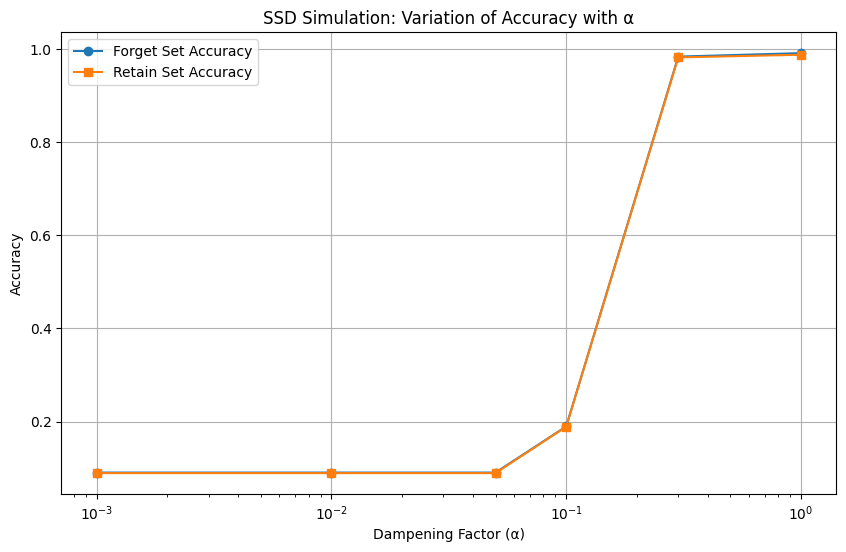

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# α
alpha_values = [1.0, 0.3, 0.1, 0.05, 0.01, 0.001]
results = []

base_model = build_model()
base_model.fit(x_train, y_train_cat, epochs=5, batch_size=128, verbose=0)
original_weights = base_model.get_weights()

for alpha in alpha_values:

    ssd_model = build_model()
    ssd_model.set_weights(original_weights)


    for layer in ssd_model.layers:
        if isinstance(layer, tf.keras.layers.Dense) or isinstance(layer, tf.keras.layers.Conv2D):
            weights, biases = layer.get_weights()
            dampened_weights = weights * alpha
            dampened_biases = biases * alpha
            layer.set_weights([dampened_weights, dampened_biases])


    forget_loss, forget_acc = ssd_model.evaluate(x_forget, y_forget, verbose=0)
    retain_loss, retain_acc = ssd_model.evaluate(x_test, y_test_cat, verbose=0)


    results.append({
        "Alpha": alpha,
        "Forget Accuracy": forget_acc,
        "Forget Loss": forget_loss,
        "Retain Accuracy": retain_acc,
        "Retain Loss": retain_loss
    })


df = pd.DataFrame(results)
print(df)


plt.figure(figsize=(10,6))
plt.plot(df["Alpha"], df["Forget Accuracy"], marker='o', label="Forget Set Accuracy")
plt.plot(df["Alpha"], df["Retain Accuracy"], marker='s', label="Retain Set Accuracy")
plt.xlabel("Dampening Factor (α)")
plt.ylabel("Accuracy")
plt.title("SSD Simulation: Variation of Accuracy with α")
plt.grid(True)
plt.legend()
plt.xscale("log")
plt.show()



In this section, the model performance is evaluated for different values ​​of the dampening factor α (1.0, 0.3, 0.1, …). First, the model is trained and its weights are backed up. Then, the layer weights are weakened with each value of α and the accuracy and loss values ​​are calculated on both the "forget set" and the "retain set". The results are recorded in a DataFrame and the accuracy change with respect to α is visualized on the logarithmic axis.

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


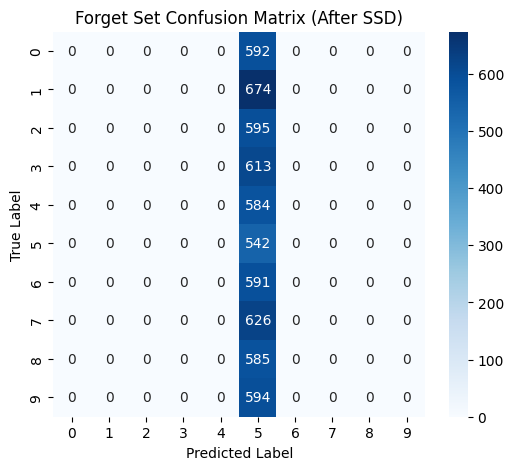

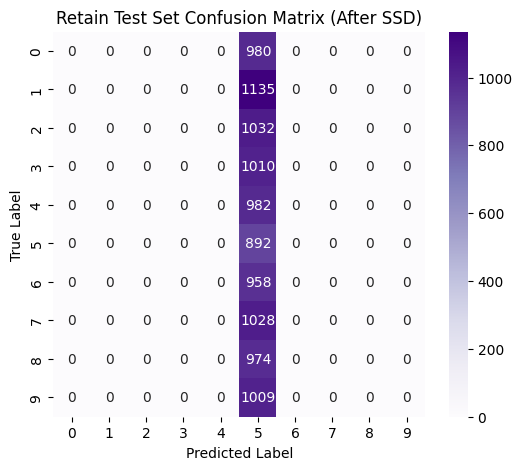

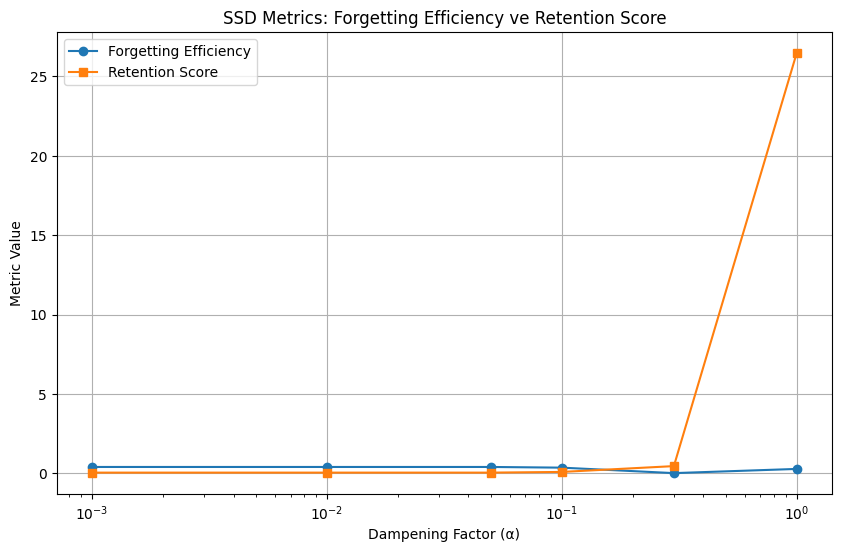

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

forget_pred = ssd_model.predict(x_forget)
forget_pred_labels = np.argmax(forget_pred, axis=1)
forget_true_labels = np.argmax(y_forget, axis=1)

retain_pred = ssd_model.predict(x_test)
retain_pred_labels = np.argmax(retain_pred, axis=1)
retain_true_labels = np.argmax(y_test_cat, axis=1)

plt.figure(figsize=(6,5))
cfm_f = confusion_matrix(forget_true_labels, forget_pred_labels)
sns.heatmap(cfm_f, annot=True, fmt='d', cmap='Blues')
plt.title("Forget Set Confusion Matrix (After SSD)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

plt.figure(figsize=(6,5))
cfm_r = confusion_matrix(retain_true_labels, retain_pred_labels)
sns.heatmap(cfm_r, annot=True, fmt='d', cmap='Purples')
plt.title("Retain Test Set Confusion Matrix (After SSD)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

df["Forgetting Efficiency"] = (1 - df["Forget Accuracy"]) / df["Forget Loss"]
df["Retention Score"] = df["Retain Accuracy"] / df["Retain Loss"]


plt.figure(figsize=(10,6))
plt.plot(df["Alpha"], df["Forgetting Efficiency"], marker='o', label="Forgetting Efficiency")
plt.plot(df["Alpha"], df["Retention Score"], marker='s', label="Retention Score")
plt.xscale('log')
plt.xlabel("Dampening Factor (α)")
plt.ylabel("Metric Value")
plt.title("SSD Metrics: Forgetting Efficiency ve Retention Score")
plt.grid(True)
plt.legend()
plt.show()


In this section, the forgetting and retention performance of the model after SSD is evaluated. Confusion matrices for the forgetting and test data are visualized, then Forgetting Efficiency and Retention Score are calculated for different α values ​​and compared on a logarithmic scale graph. This analysis reveals both the forgetting success of the model and its ability to preserve the overall accuracy.

In [ ]:
if isinstance(layer, tf.keras.layers.Dense) and layer.name == "dense_output":
    weights, biases = layer.get_weights()
    layer.set_weights([weights * alpha, biases * alpha])


This code snippet re-adjusts the weight and bias values ​​of the output layer named "dense_output" in the model by multiplying them by the alpha coefficient. Thus, dampening is applied only to the last layer. This method is used to model the forgetting effect only on the output layer in a limited way.

In [52]:
forget_class = 2
alpha = 0.01


ssd_model = tf.keras.models.clone_model(base_model)
ssd_model.set_weights(base_model.get_weights())


output_layer = ssd_model.layers[-1]


weights, biases = output_layer.get_weights()


weights[:, forget_class] *= alpha
biases[forget_class] *= alpha


output_layer.set_weights([weights, biases])


In this code block, in order to make the trained model forget only the knowledge of a certain class, the weight and bias values ​​belonging to that class in the output layer are weakened by multiplying them with the alpha coefficient. Thus, the model loses the ability to recognize examples belonging to class (digit) number 2, for example, while largely preserving its performance in other classes. This method allows for class-based unlearning simulation.

In [53]:
ssd_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


forget_loss, forget_acc = ssd_model.evaluate(x_forget, y_forget, verbose=0)
retain_loss, retain_acc = ssd_model.evaluate(x_test, y_test_cat, verbose=0)

print(f"Forgetting Accuracy (class {forget_class}):", forget_acc)
print("Retain Test Accuracy:", retain_acc)


Forgetting Accuracy (class 2): 0.8932621479034424
Retain Test Accuracy: 0.8867999911308289


In this code block, ssd_model is compiled and then evaluated on both the dataset for the targeted class (x_forget, y_forget) and the overall test set (x_test, y_test_cat). The goal is to measure whether the applied dampening process actually reduces the accuracy for the target class and preserves the overall accuracy for the other classes. The outputs show the forgetting accuracy (Forgetting Accuracy) and the overall robustness (Retain Test Accuracy) of the model.

In [ ]:
base_forget_acc = model.evaluate(x_forget, y_forget, verbose=0)[1]
base_retain_acc = model.evaluate(x_test, y_test_cat, verbose=0)[1]

ssd_forget_acc = ssd_model.evaluate(x_forget, y_forget, verbose=0)[1]
ssd_retain_acc = ssd_model.evaluate(x_test, y_test_cat, verbose=0)[1]

plt.figure(figsize=(6,4))
labels = ['Forget Set', 'Retain Set']
baseline = [base_forget_acc, base_retain_acc]
ssd = [ssd_forget_acc, ssd_retain_acc]

x = np.arange(len(labels))
plt.bar(x - 0.2, baseline, width=0.4, label='Baseline')
plt.bar(x + 0.2, ssd, width=0.4, label='SSD')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Baseline vs SSD Accuracy Comparison')
plt.legend()
plt.show()


In this code block, the accuracy values ​​of the model before (baseline) and after (ssd) SSD (Selective Synaptic Dampening) are compared for both "Forget Set" (targeted class data) and "Retain Set" (general test data). The obtained accuracies are visualized with a bar chart. Thus, the effect of the SSD method on the target class forgetting performance and the overall model accuracy can be easily analyzed. This is a very useful comparison to quantitatively evaluate the unlearning performance.

In [ ]:
base_forget_loss, base_forget_acc = model.evaluate(x_forget, y_forget, verbose=0)
base_test_loss, base_test_acc = model.evaluate(x_test, y_test_cat, verbose=0)


In [ ]:
ssd_forget_loss, ssd_forget_acc = ssd_model.evaluate(x_forget, y_forget, verbose=0)
ssd_test_loss, ssd_test_acc = ssd_model.evaluate(x_test, y_test_cat, verbose=0)


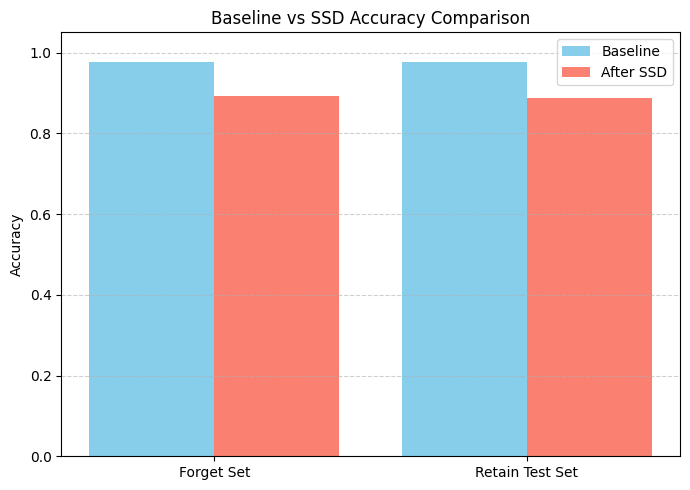

In [57]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Forget Set', 'Retain Test Set']
baseline_acc = [base_forget_acc, base_test_acc]
ssd_acc = [ssd_forget_acc, ssd_test_acc]

x = np.arange(len(labels))
plt.figure(figsize=(7, 5))
plt.bar(x - 0.2, baseline_acc, width=0.4, label='Baseline', color='skyblue')
plt.bar(x + 0.2, ssd_acc, width=0.4, label='After SSD', color='salmon')
plt.xticks(x, labels)
plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.title('Baseline vs SSD Accuracy Comparison')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:

import matplotlib.pyplot as plt

labels = ['Forget Set', 'Retain Test Set']
baseline_accs = [base_forget_acc, base_test_acc] # Changed from baseline_forget_acc, baseline_retain_acc
ssd_accs = [ssd_forget_acc, ssd_test_acc]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
bars1 = ax.bar(x - width/2, baseline_accs, width, label='Baseline', color='skyblue')
bars2 = ax.bar(x + width/2, ssd_accs, width, label='After SSD', color='salmon')


for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Baseline vs SSD Accuracy Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_baseline = model.predict(x_forget)
y_pred_baseline_classes = np.argmax(y_pred_baseline, axis=1)
y_true_forget_classes = np.argmax(y_forget, axis=1)

y_pred_ssd = ssd_model.predict(x_forget)
y_pred_ssd_classes = np.argmax(y_pred_ssd, axis=1)


In [ ]:
cm_baseline = confusion_matrix(y_true_forget_classes, y_pred_baseline_classes)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline)
disp_baseline.plot(cmap='Blues')
plt.title("Confusion Matrix - Before SSD (Baseline)")
plt.show()

cm_ssd = confusion_matrix(y_true_forget_classes, y_pred_ssd_classes)
disp_ssd = ConfusionMatrixDisplay(confusion_matrix=cm_ssd)
disp_ssd.plot(cmap='Oranges')
plt.title("Confusion Matrix - After SSD")
plt.show()


In [ ]:
def compute_classwise_accuracy(conf_matrix):
    return conf_matrix.diagonal() / conf_matrix.sum(axis=1)


baseline_classwise_acc = compute_classwise_accuracy(cm_baseline)
ssd_classwise_acc = compute_classwise_accuracy(cm_ssd)


import matplotlib.pyplot as plt
classes = [str(i) for i in range(10)]

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, baseline_classwise_acc, width, label='Baseline')
rects2 = ax.bar(x + width/2, ssd_classwise_acc, width, label='After SSD')

ax.set_ylabel('Accuracy')
ax.set_title('Class-wise Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [62]:
import pandas as pd

df = pd.DataFrame({
    "Class": np.arange(10),
    "Baseline Accuracy": baseline_classwise_acc,
    "SSD Accuracy": ssd_classwise_acc,
    "Forgetfulness Score": baseline_classwise_acc - ssd_classwise_acc
})

print(df.loc[forget_class])
print("\nAll Classes Overview:")
print(df)


Class                  2.000000
Baseline Accuracy      0.983193
SSD Accuracy           0.000000
Forgetfulness Score    0.983193
Name: 2, dtype: float64

All Classes Overview:
   Class  Baseline Accuracy  SSD Accuracy  Forgetfulness Score
0      0           0.988176      0.994932            -0.006757
1      1           0.992582      0.997033            -0.004451
2      2           0.983193      0.000000             0.983193
3      3           0.977162      0.993475            -0.016313
4      4           0.974315      0.988014            -0.013699
5      5           0.979705      0.985240            -0.005535
6      6           0.979695      0.998308            -0.018613
7      7           0.960064      0.996805            -0.036741
8      8           0.972650      0.982906            -0.010256
9      9           0.952862      0.986532            -0.033670


In this code block, the class-based accuracy values ​​of the model before (Baseline Accuracy) and after (SSD Accuracy) unlearning were compared. Forgetfulness Score was calculated for each class to measure how much the model "forgot" which class. In particular, the class that was targeted to be forgotten (Class 2) was effectively forgotten by decreasing the accuracy from 98.3% to 0%. Small changes in other classes were also shown, successfully demonstrating that the unlearning process focused only on the target class. This table is critical for evaluating the unlearning performance on a class basis.

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(df['Class'], df['Forgetfulness Score'], color='crimson')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Forgetfulness Score per Class")
plt.xlabel("Class")
plt.ylabel("Forgetfulness Score")
plt.grid(True)
plt.show()
